## Knut Knut Transport — Fortuna Model (Hand-in 1)

**Authors:** Cornelius Brandt, Maximilian Eckstein, Mohammad Itani  
**Date:** 2025-09-24
**Course:** IKT110 Artificial Intelligence Architecture

**Notebook summary (short):**  
This notebook loads and tidies `traffic.jsonl`, converts times (HH:MM → minutes since midnight), computes trip durations, scales the departure-time feature (z-score), and visualizes duration vs. departure-time per route. It prepares clean features and metadata for training per-route Fortuna models and for serializing a model bundle via `pickle` for the Flask app.

**Note:** 
Assisted by ChatGPT (GPT-5 Thinking) for plotting and data cleaning/preparation (including scaling of the input feature “departure time”).

### Imports & Setup

In [8]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt

# Matplotlib defaults (clean, readable; no seaborn/styles)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.alpha"] = 0.6

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Robust data path resolution (works in notebooks/WSL/VS Code)
DATA_FILE_NAME = "traffic.jsonl"

def find_data_file(name: str = DATA_FILE_NAME) -> Path:
    """
    Search upwards from the current working directory for a 'data/<name>' file.
    Raises FileNotFoundError if not found.
    """
    cwd = Path.cwd()
    for base in [cwd, *cwd.parents]:
        candidate = base / "data" / name
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not find data/{name} from {cwd}")

# Helper functions for pickling/unpickling model bundles
def save_model_bundle(bundle: dict, path : Path) -> None:
    with open(path, "wb") as f:
        pickle.dump(bundle, f)

def load_model_bundle(path: Path) -> dict:
    with open(path, "rb") as f:
        return pickle.load(f)
    
OUTPUT_FILE = "fast_and_furious_AI.pkl"

DATA_PATH = find_data_file()
print(f"Using data file: {DATA_PATH}")

Using data file: /home/maxge/studies/bachelor_mechatronics/semester_5/exchange_UiA/IKT110_artificial_intelligence_architecture/IKT110_eckstein/handins/handin_1/data/traffic.jsonl


### Data loading & feature engineering

- Read `traffic.jsonl` into a tidy DataFrame (robust to empty/BOM lines).
- Parse `departure` / `arrival` (HH:MM) to minutes since midnight.
- Compute `duration_min = arrival - departure` (guard for wrap-around).
- Create a **global** scaler for the input feature (`dep_min`) — z-score by default.
- Add the scaled feature `dep_scaled` to the DataFrame.

In [9]:
def _hhmm_to_minutes(hhmm: str) -> int:
    """Convert 'HH:MM' to minutes since midnight (e.g., '07:30' to 450)."""
    h, m = hhmm.split(":")
    return int(h) * 60 + int(m)

def read_jsonl_data(path) -> pd.DataFrame:
    """
    Minimal-robust JSONL reader:
    - UTF-8 with BOM tolerant
    - skips empty lines
    - raises a clear error on malformed lines
    """
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for lineno, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            try:
                rows.append(json.loads(s))
            except Exception as e:
                raise ValueError(f"JSONL parse error at line {lineno}: {e}")
    if not rows:
        raise ValueError("File is empty or contains no valid JSON lines.")
    return pd.DataFrame(rows)

def load_traffic_df(jsonl_path) -> pd.DataFrame:
    """
    Return a tidy DataFrame with:
      - dep_min / arr_min (minutes since midnight)
      - duration_min (arrival - departure, wrapped if needed)
    """
    df = read_jsonl_data(jsonl_path)

    # Dataset often uses a 'depature' typo; normalize to 'departure'
    if "depature" in df.columns and "departure" not in df.columns:
        df = df.rename(columns={"depature": "departure"})

    # Parse times
    dep_min = df["departure"].map(_hhmm_to_minutes)
    arr_min = df["arrival"].map(_hhmm_to_minutes)

    # Duration; if arrival < departure (past midnight), add 24h
    duration = arr_min - dep_min
    duration = duration.where(duration >= 0, duration + 24 * 60)

    return df.assign(dep_min=dep_min, arr_min=arr_min, duration_min=duration)

# Scaling helpers (z-score default; min-max optional)

def fit_scaler(dep_min: pd.Series, method: str = "zscore") -> dict:
    """
    Fit a simple scaler on dep_min over ALL routes.
    method: "zscore" (recommended) or "minmax".
    Returns parameters needed for inference (store in pickle later).
    """
    x = dep_min.to_numpy().astype(float)
    params = {
        "type": method,
        "dep_min_min": float(np.min(x)),
        "dep_min_max": float(np.max(x)),
    }
    if method == "zscore":
        mu = float(np.mean(x))
        sigma = float(np.std(x, ddof=0)) or 1.0
        params.update({"mu": mu, "sigma": sigma})
    elif method == "minmax":
        rng = params["dep_min_max"] - params["dep_min_min"] or 1.0
        params.update({"min": params["dep_min_min"], "max": params["dep_min_max"], "range": float(rng)})
    else:
        raise ValueError("method must be 'zscore' or 'minmax'")
    return params

def transform_dep_min(dep_min: pd.Series, scaler: dict, clip_out_of_range: bool = False) -> np.ndarray:
    """
    Apply the scaler to dep_min. Optionally clamp to training range (for inference).
    """
    x = dep_min.to_numpy().astype(float)
    if clip_out_of_range:
        lo, hi = scaler["dep_min_min"], scaler["dep_min_max"]
        x = np.clip(x, lo, hi)

    if scaler["type"] == "zscore":
        return (x - scaler["mu"]) / scaler["sigma"]
    elif scaler["type"] == "minmax":
        return (x - scaler["min"]) / scaler["range"]
    else:
        raise ValueError("unknown scaler type")

# -------------------------------------------------------------
# Execute: build df & scaled feature

df = load_traffic_df(DATA_PATH)

SCALER_METHOD = "zscore"  # or "minmax"
scaler = fit_scaler(df["dep_min"], method=SCALER_METHOD)

mu = scaler.get("mu")
sigma = scaler.get("sigma")

# Add scaled input feature for model fitting
df["dep_scaled"] = transform_dep_min(df["dep_min"], scaler, clip_out_of_range=False)

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   road          1031 non-null   object 
 1   departure     1031 non-null   object 
 2   arrival       1031 non-null   object 
 3   dep_min       1031 non-null   int64  
 4   arr_min       1031 non-null   int64  
 5   duration_min  1031 non-null   int64  
 6   dep_scaled    1031 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 56.5+ KB


,road,departure,arrival,dep_min,arr_min,duration_min,dep_scaled
0,B->C->E,13:17,15:25,797,925,128,0.392130
1,A->C->E,07:07,08:47,427,527,100,-1.739968
2,A->C->E,07:59,09:32,479,572,93,-1.440322
3,B->C->E,14:21,16:29,861,989,128,0.760926
4,B->C->D,10:09,11:13,609,673,64,-0.691206
5,B->C->D,07:44,09:53,464,593,129,-1.526758
6,B->C->E,13:44,15:29,824,929,105,0.547716
7,B->C->D,09:11,10:28,551,628,77,-1.025427
8,A->C->E,08:19,10:00,499,600,101,-1.325073
9,A->C->E,09:05,10:47,545,647,102,-1.060002


### Exploratory plots (concise set)

We keep **three** clear, decision-oriented visualizations:

1) **Duration vs. departure (per route) — with binned mean**  
   _Goal:_ Inspect the functional relationship used for model fitting.  
   _Read it like this:_ Points = individual trips; the thick line (binned mean) reveals the trend (often U-shaped). If a smooth U appears, a **quadratic** per route is a good baseline.

2) **Best route by time (binned)**  
   _Goal:_ Policy view — which route tends to be fastest at each departure time window.  
   _Read it like this:_ The y-axis shows the route label; the step curve tells you which route “wins” for each time bin.

3) **Hourly mean ± std per route**  
   _Goal:_ Variability and stability check by hour.  
   _Read it like this:_ Mean duration per hour with error bars (standard deviation). Useful to see spread/uncertainty patterns by route/time.

> If you prefer only **two** plots, keep (1) and (2).


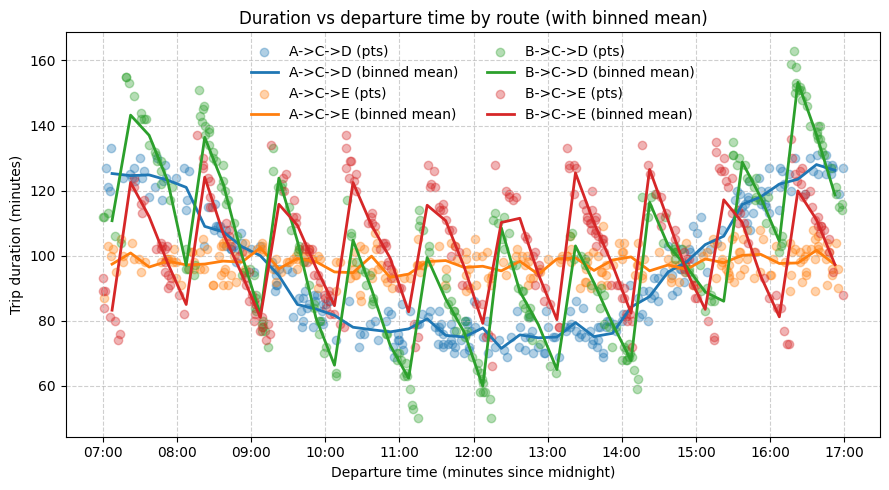

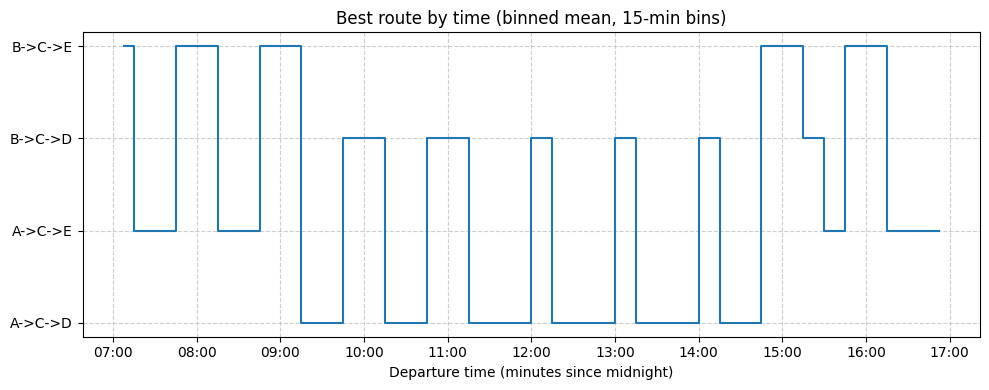

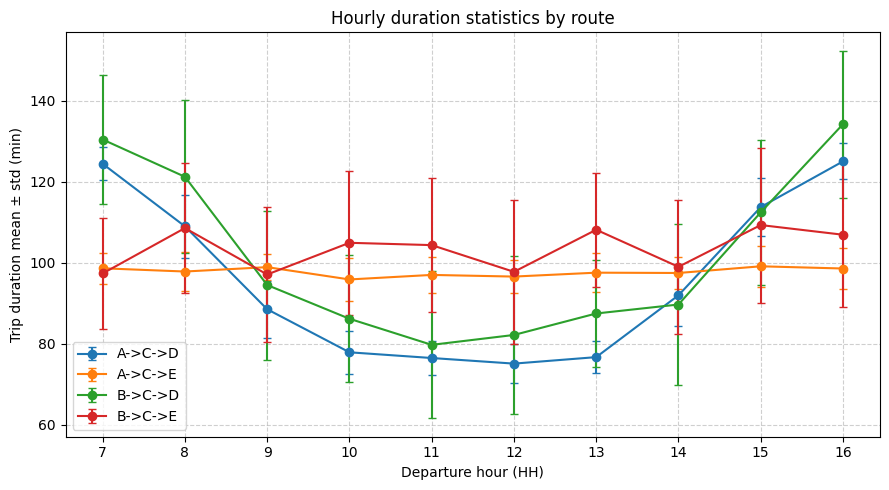

In [10]:
def plot_scatter_with_binned_mean(df: pd.DataFrame, bin_minutes: int = 15) -> None:
    """
    Scatter: duration_min vs dep_min per route + binned-mean trendline.
    Bin width controls the smoothing strength.
    """
    dep_min_min = int(df["dep_min"].min())
    dep_min_max = int(df["dep_min"].max())
    edges = list(range((dep_min_min // bin_minutes) * bin_minutes,
                       ((dep_min_max // bin_minutes) + 1) * bin_minutes + 1,
                       bin_minutes))
    centers = [(edges[i] + edges[i+1]) / 2 for i in range(len(edges) - 1)]

    fig, ax = plt.subplots()
    for route, sub in df.groupby("road", sort=True):
        ax.scatter(sub["dep_min"], sub["duration_min"], alpha=0.35, label=f"{route} (pts)")
        bin_ids = pd.cut(sub["dep_min"], bins=edges, right=False, include_lowest=True, labels=False)
        binned = (pd.DataFrame({"bin": bin_ids, "duration": sub["duration_min"]})
                  .dropna()
                  .groupby("bin", as_index=False)["duration"].mean())
        if not binned.empty:
            x_line = [centers[int(i)] for i in binned["bin"]]
            y_line = binned["duration"].to_list()
            ax.plot(x_line, y_line, linewidth=2, label=f"{route} (binned mean)")

    ax.set_xlabel("Departure time (minutes since midnight)")
    ax.set_ylabel("Trip duration (minutes)")
    ax.set_title("Duration vs departure time by route (with binned mean)")
    start_hour = dep_min_min // 60
    end_hour = math.ceil(dep_min_max / 60)
    xticks = [h * 60 for h in range(start_hour, end_hour + 1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in range(start_hour, end_hour + 1)])
    ax.legend(loc="best", ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()


def plot_best_route_by_time(df: pd.DataFrame, bin_minutes: int = 15) -> None:
    """
    For each time bin, compute the mean duration per route and plot the argmin (best route).
    The y-axis is categorical via integer codes with tick labels as route names.
    """
    dep_min_min = int(df["dep_min"].min())
    dep_min_max = int(df["dep_min"].max())
    edges = list(range((dep_min_min // bin_minutes) * bin_minutes,
                       ((dep_min_max // bin_minutes) + 1) * bin_minutes + 1,
                       bin_minutes))
    centers = np.array([(edges[i] + edges[i+1]) / 2 for i in range(len(edges) - 1)])

    routes = sorted(df["road"].unique().tolist())

    # Build a matrix of binned mean durations: rows=bins, cols=routes
    M = np.full((len(centers), len(routes)), np.nan)
    for j, route in enumerate(routes):
        sub = df[df["road"] == route]
        bin_ids = pd.cut(sub["dep_min"], bins=edges, right=False, include_lowest=True, labels=False)
        binned = pd.DataFrame({"bin": bin_ids, "duration": sub["duration_min"]}).dropna()
        if not binned.empty:
            means = binned.groupby("bin")["duration"].mean()
            for b, val in means.items():
                M[int(b), j] = val

    # Argmin per bin (skip rows that are all NaN)
    best_idx = []
    valid_centers = []
    for i in range(M.shape[0]):
        row = M[i, :]
        if np.all(np.isnan(row)):
            continue
        best_idx.append(int(np.nanargmin(row)))
        valid_centers.append(centers[i])

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(valid_centers, best_idx, drawstyle="steps-mid")
    ax.set_yticks(range(len(routes)))
    ax.set_yticklabels(routes)
    ax.set_xlabel("Departure time (minutes since midnight)")
    ax.set_title(f"Best route by time (binned mean, {bin_minutes}-min bins)")

    start_hour = dep_min_min // 60
    end_hour = math.ceil(dep_min_max / 60)
    xticks = [h * 60 for h in range(start_hour, end_hour + 1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in range(start_hour, end_hour + 1)])
    plt.tight_layout()
    plt.show()


def plot_hourly_means_with_errorbars(df: pd.DataFrame) -> None:
    """
    Hourly mean duration ± standard deviation, per route.
    Useful to see variability (uncertainty) patterns by hour/route.
    """
    tmp = df.copy()
    tmp["hour"] = (tmp["dep_min"] // 60).astype(int)

    fig, ax = plt.subplots(figsize=(9, 5))
    for route, sub in tmp.groupby("road", sort=True):
        g = sub.groupby("hour")["duration_min"].agg(["mean", "std"]).reset_index()
        ax.errorbar(g["hour"], g["mean"], yerr=g["std"], fmt="-o", capsize=3, label=route)

    ax.set_xlabel("Departure hour (HH)")
    ax.set_ylabel("Trip duration mean ± std (min)")
    ax.set_title("Hourly duration statistics by route")
    ax.set_xticks(sorted(tmp["hour"].unique()))
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
plot_scatter_with_binned_mean(df, bin_minutes=15)
plot_best_route_by_time(df, bin_minutes=15)
plot_hourly_means_with_errorbars(df)

### Fortuna & training data

This cell prepares the per-route training arrays and a very simple **Fortuna** optimizer:

- `create_xs_ys(data, route)`: extracts inputs (`dep_scaled`) and targets (`duration_min`) for a given short route code (`ACE`, `ACD`, `BCE`, `BCD`). Returns 1-D NumPy arrays; no shuffling/splitting here.
- `sample_theta(...)`: uniform random initialization of a parameter vector within `[min_theta, max_theta]`.
- `get_loss(...)`: RMSE in minutes between `y_true` and `y_pred`.
- `fortuna(func, xs, ys, ...)`: **random search** over 10,000 samples. It calls your provided model function `func(xs, theta, scaler=...)`, evaluates RMSE, and keeps the best parameter vector.

Notes:
- Reproducibility depends on the global NumPy RNG seed (set earlier if needed).

In [11]:
def create_xs_ys(data, route):
    """
    Extract 1-D arrays (xs, ys) for a single route.
      xs: dep_scaled (model input feature)
      ys: duration_min (target in minutes)
    route: one of {"ACE","ACD","BCE","BCD"} mapping to the full labels.
    """
    df = data

    if route == "ACE":
        # A->C->E
        xs = df.loc[df["road"] == "A->C->E", "dep_scaled"].to_numpy()
        ys = df.loc[df["road"] == "A->C->E", "duration_min"].to_numpy()
    elif route == "ACD":
        # A->C->D
        xs = df.loc[df["road"] == "A->C->D", "dep_scaled"].to_numpy()
        ys = df.loc[df["road"] == "A->C->D", "duration_min"].to_numpy()
    elif route == "BCE":
        # B->C->E
        xs = df.loc[df["road"] == "B->C->E", "dep_scaled"].to_numpy()
        ys = df.loc[df["road"] == "B->C->E", "duration_min"].to_numpy()
    elif route == "BCD":
        # B->C->D
        xs = df.loc[df["road"] == "B->C->D", "dep_scaled"].to_numpy()
        ys = df.loc[df["road"] == "B->C->D", "duration_min"].to_numpy()

    return xs, ys

# ------------------------ Fortuna-related functions --------------------------

def sample_theta(range_min, range_max, size_theta):
    """Uniform random initialization of a parameter vector of length `size_theta`
    within [range_min, range_max]."""
    return np.random.uniform(range_min, range_max, size_theta)

def get_loss(y_true, y_pred):
    """Root Mean Squared Error (RMSE) in minutes."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def fortuna(func, xs, ys, size_theta, min_theta, max_theta, scaler=False):
    """
    Minimal Fortuna optimizer via random search:
      - Draw 10,000 random parameter vectors (uniform in [min_theta, max_theta])
      - Evaluate model: y_pred = func(xs, theta, scaler=scaler)
      - Keep the parameter vector with the lowest RMSE

    Args:
      func: callable like func(xs, theta, scaler=...) -> y_pred
      xs, ys: 1-D arrays (inputs, targets)
      size_theta: number of parameters in theta
      min_theta, max_theta: bounds for uniform sampling
      scaler: forwarded to `func` (if your func needs it)

    Returns:
      (best_theta, best_loss)
    """
    best_loss = float('inf')
    best_theta = None

    for _ in range(10000):  # simple random search over the parameter space
        curr_theta = sample_theta(min_theta, max_theta, size_theta)
        y_pred = func(xs, curr_theta, scaler=scaler)
        curr_loss = get_loss(ys, y_pred)

        if curr_loss < best_loss:
            best_loss = curr_loss
            best_theta = curr_theta

    return best_theta, best_loss

# ------------------------ Build per-route training arrays ---------------------

xs_ACE, ys_ACE = create_xs_ys(df, "ACE")
xs_ACD, ys_ACD = create_xs_ys(df, "ACD")
xs_BCE, ys_BCE = create_xs_ys(df, "BCE")
xs_BCD, ys_BCD = create_xs_ys(df, "BCD")

### Models (linear & quadratic)

Two simple, explainable regression models for route duration:

- `linear_model(x, theta, scaler=False)`  
  - **Form:** \( \hat y = a \cdot x + b \)  
  - If `scaler=True`, a global multiplicative scale is applied: \( (\;a x + b\;) \cdot s \).  
  - **Theta layout:**  
    - `scaler=False` → `theta = [a, b]`  
    - `scaler=True`  → `theta = [a, b, s]`

- `polynomial_model(x, theta, scaler=False)` (quadratic)  
  - **Form:** \( \hat y = a_2 x^2 + a_1 x + a_0 \)  
  - If `scaler=True`, a global multiplicative scale is applied: \( (\;a_2 x^2 + a_1 x + a_0\;) \cdot s \).  
  - **Theta layout:**  
    - `scaler=False` → `theta = [a_2, a_1, a_0]`  
    - `scaler=True`  → `theta = [a_2, a_1, a_0, s]`

> `x` is your scaled input feature (`dep_scaled`), `theta` are the Fortuna-optimized parameters. The optional output scale can help absorb systematic level shifts without changing the curve shape.

In [12]:
def linear_model(x, theta, scaler=False):
    # y = a*x + b   (optionally scaled by s)
    # theta: [a, b] if scaler=False; [a, b, s] if scaler=True
    if scaler:
        return (x * theta[0] + theta[1]) * theta[2]
    return x * theta[0] + theta[1]

def polynomial_model(x, theta, scaler=False):
    # y = a2*x^2 + a1*x + a0   (optionally scaled by s)
    # theta: [a2, a1, a0] if scaler=False; [a2, a1, a0, s] if scaler=True
    if scaler:
        return (theta[0] * x**2 + theta[1] * x + theta[2]) * theta[3]
    return theta[0] * x**2 + theta[1] * x + theta[2]

### Train route models with Fortuna & serialize bundle

This cell:
- Fits **one model per route** using the minimal Fortuna random search:
  - `ACE`: linear (2 params, no extra output scaler)
  - `ACD`: quadratic (3 params, no extra output scaler)
  - `BCE`: linear (3 params **with** output scaler)
  - `BCD`: quadratic (4 params **with** output scaler)
- Prints the best parameter vector (`theta`) and RMSE (`loss`) per route.
- Packs everything into a single **model bundle** (`fortuna_results`) including the **scaling metadata**.
- Saves the bundle to `OUTPUT_FILE` via `save_model_bundle(...)`.

> Notes:
> - Ensure your **scaler variables** are available: `mu` and `sigma` (e.g., from your earlier `scaler` dict).  
> - Ensure `OUTPUT_FILE` and `save_model_bundle` are defined (e.g., `OUTPUT_FILE = Path("code/model_bundle.pkl")`).

In [13]:
# Model fitting with Fortuna
theta_ACE, loss_ACE = fortuna(linear_model, xs_ACE, ys_ACE, 2, -1, 100)                     # ACE: linear (a, b)
theta_ACD, loss_ACD = fortuna(polynomial_model, xs_ACD, ys_ACD, 3, -1, 80)                  # ACD: quadratic (a2, a1, a0)
theta_BCE, loss_BCE = fortuna(linear_model, xs_BCE, ys_BCE, 3, -1, 20, scaler=True)         # BCE: linear + scale (a, b, s)
theta_BCD, loss_BCD = fortuna(polynomial_model, xs_BCD, ys_BCD, 4, -0.5, 15, scaler=True)   # BCD: quadratic + scale (a2, a1, a0, s)

print("----------------------------------------------")
print("Best theta ACE:", theta_ACE)
print("Best loss ACE:", loss_ACE)
print("----------------------------------------------")
print("Best theta ACD:", theta_ACD)
print("Best loss ACD:", loss_ACD)
print("----------------------------------------------")
print("Best theta BCE:", theta_BCE)
print("Best loss BCE:", loss_BCE)
print("----------------------------------------------")
print("Best theta BCD:", theta_BCD)
print("Best loss BCD:", loss_BCD)

# Bundle for serialization (expects mu/sigma to be set earlier)
fortuna_results = {
    "Scaling":{
        "method": SCALER_METHOD,
        "mu": mu,
        "sigma": sigma
    },
    "ACE": {
        "theta": theta_ACE,
        "loss": loss_ACE,
        "scaler": False
    },
    "ACD": {
        "theta": theta_ACD,
        "loss": loss_ACD,
        "scaler": False
    },
    "BCE": {
        "theta": theta_BCE,
        "loss": loss_BCE,
        "scaler": True
    },
    "BCD": {
        "theta": theta_BCD,
        "loss": loss_BCD,
        "scaler": True
    }
}

# Persist the bundle (ensure OUTPUT_FILE and save_model_bundle(...) exist)
save_model_bundle(fortuna_results, OUTPUT_FILE)

----------------------------------------------
Best theta ACE: [-0.35571662 97.81383349]
Best loss ACE: 4.599373419918656
----------------------------------------------
Best theta ACD: [22.70611669  3.57680138 73.22655357]
Best loss ACD: 5.926330564647699
----------------------------------------------
Best theta BCE: [ 0.40736676 15.80223442  6.49329796]
Best loss BCE: 16.85196528488482
----------------------------------------------
Best theta BCD: [ 3.06057224  0.04022926 13.01449045  6.2335207 ]
Best loss BCD: 18.324153537403948


### Visualizing model fits (per route)

Each panel shows **training data** (scatter) and the **Fortuna-fitted model** (red line) for one route.

- **X-axis:** `dep_scaled` (z-scored departure time).
- **Y-axis:** `duration_min` (observed minutes).
- **Red line:** prediction from the selected model (`linear_model` or `polynomial_model`) with the learned `theta`.
- Use this to sanity-check curve shape (e.g., U-form for quadratic) and alignment with data; large systematic gaps suggest revisiting the model family or parameter ranges.

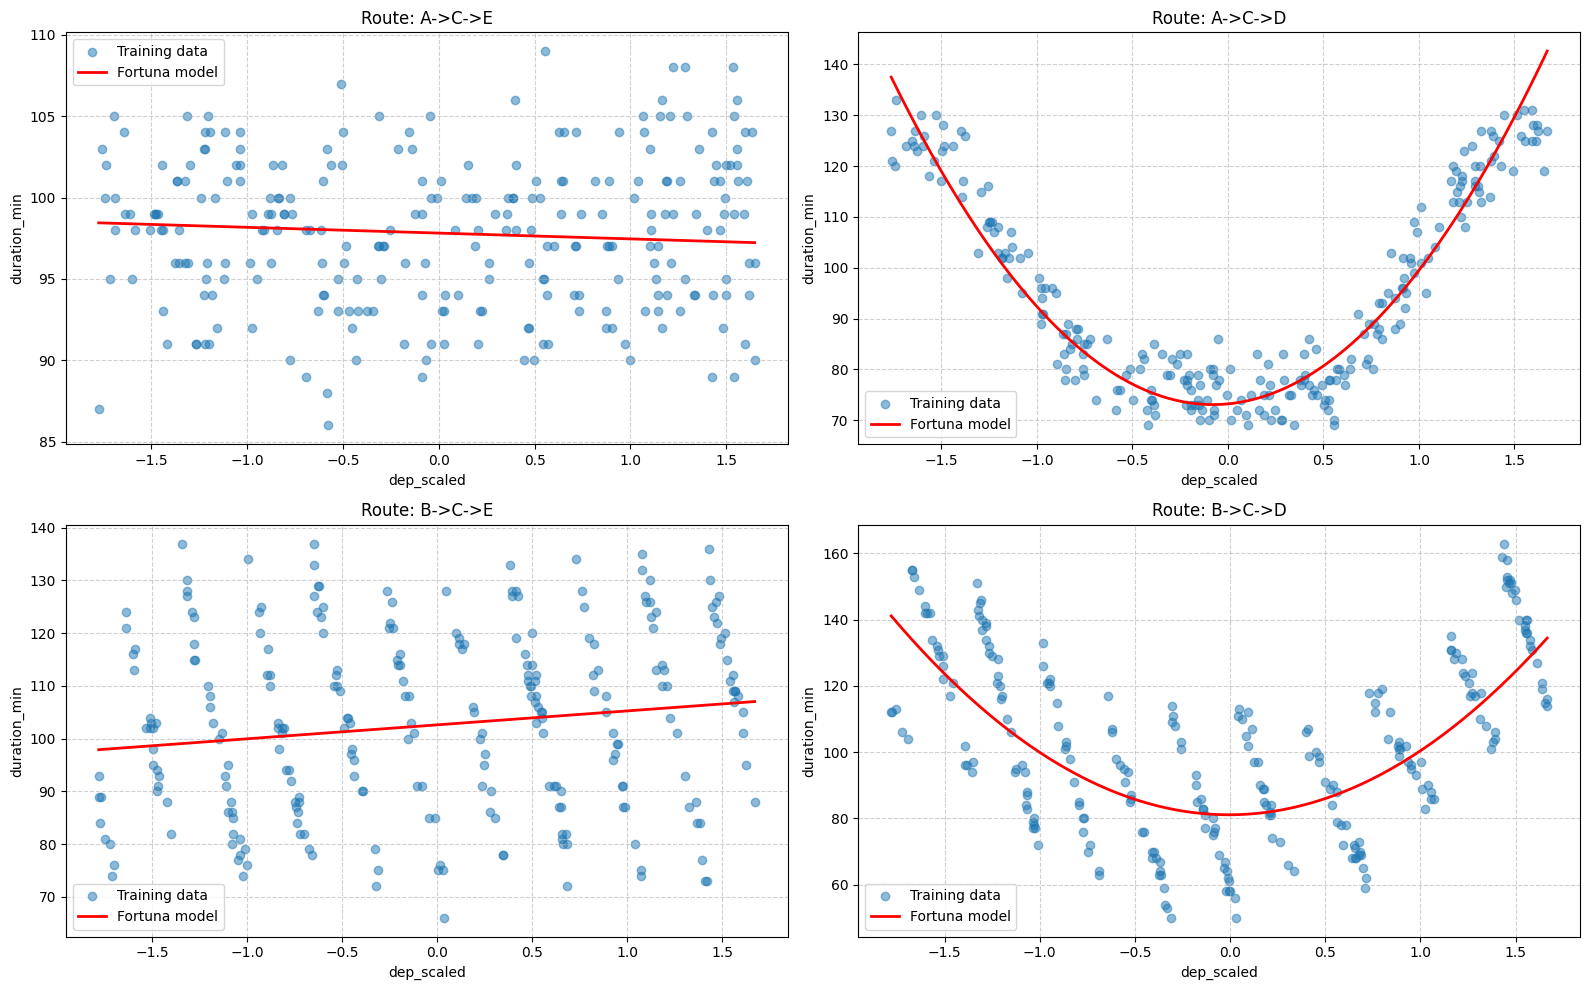

In [14]:
routes = [
    ("A->C->E", xs_ACE, ys_ACE, linear_model, theta_ACE, False),
    ("A->C->D", xs_ACD, ys_ACD, polynomial_model, theta_ACD, False),
    ("B->C->E", xs_BCE, ys_BCE, linear_model, theta_BCE, True),
    ("B->C->D", xs_BCD, ys_BCD, polynomial_model, theta_BCD, True),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, (route, xs, ys, model_func, theta, scaler) in enumerate(routes):
    ax = axes[i]
    ax.scatter(xs, ys, alpha=0.5, label="Training data")
    xs_line = np.linspace(xs.min(), xs.max(), 200)
    ys_line = model_func(xs_line, theta, scaler=scaler)
    ax.plot(xs_line, ys_line, color="red", linewidth=2, label="Fortuna model")
    ax.set_title(f"Route: {route}")
    ax.set_xlabel("dep_scaled")
    ax.set_ylabel("duration_min")
    ax.legend()

plt.tight_layout()
plt.show()
